# "MicroMouse" : Motor and Battery Selection

Below is an analysis used to determine a suitable motor for a robot designed for Dr. MacIver's lab. The intention of this robot is to act as a predeator and chase mice around a habit.
***

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import csv

## Design Contraints / Requirements

The robot will operate a hexagonal shapped habit with vinyl flooring that is ~3m in length across longest vertices and has various hexagonal shaped obstacles. Ideally, the robot will fit through the smallest potential opening, which given the obstacle spacing is a litte larger than 6cm. 

The mice move up to 1.7 m/s. If possible we would like the robot to move around 3 m/s, but at minimum it should be quicker than the mice, so at least 2 m/s linearly. The micromouse robots use cornering speed around 1 m/s and turn between 60 and 120 degrees.  

## Battery Calculations 

The battery I've been modeling with is rated at a capactiy of 950mAh, V = 7.4 and C = 25 constant, 50 burst. 

https://hobbyking.com/en_us/turnigy-nano-tech-950mah-2s-25-50c-lipo-pack.html?queryID=1eaac594597e79e054b2ad91f52d2667&objectID=47397&indexName=hbk_live_magento_en_us_products

At shortest time and maximum current draw:

$60min / 25C = 2.4 min$

$I = 0.95(25) = 23.75 A$

From our previous discussions, we said that given a 45min - 1hour experiment, we can predict that a battery should last on average at least 15 minutes. So for 15 minutes...

$60min / 15min = 4C$

For 4C, I can draw up to... 

$I = .95(4) = 3.8A$

### Simple Mechanical Calculations:

The simpliest spec we can calculate first is a maximum angular velocity. If we happen to find a motor that doesnt require a gear reduction, what angular speed would we need to operate at in order to achieve a linear speed of 3 m/s?

Given the equation $v = \omega r$ we can determine that for the maximum angular velocity, $\omega$, we need to use the smallest possible radius $r$. 

Most motors have a diamter of 10mm (1 cm) or above, so lets assume a smallest wheel radius to be 7.5mm (0.75cm) so we can safety algin the motor with the wheels. 

#### Solving for $\omega$ ...

$\omega_\max = \frac{v}{r} = \frac{3 m/{s}^2}{0.0075m} = 400 rad/s$


In [2]:
v_max = 3
r_min = 0.0075

omega_max = v_max / r_min

print(f"Maximum angular speed is {omega_max} rad/s")

Maximum angular speed is 400.0 rad/s


#### Converting to RMP...

$RPM_\max = \frac{60\omega}{2\pi} = \frac{60(400)}{2\pi} = 3,800$

All the Maxon motors I looked at easily meet this maximum RPM requirment, which is great because it means we can adjust the wheel radius to be larger if need be. The larger the wheel radius, the less RPM the motors need to procude to drive at a linear speed of 3m/s. However, speed and torque have an inverse relationship which needs to be taken into consideration when deciding on radius size and motor selection. 

In [3]:
RPM_max = (60*omega_max) / (2*math.pi)
print(f"Maximum angular speed is {RPM_max} RPM")

Maximum angular speed is 3819.7186342054883 RPM


### Now that we have a gauge on our velocity needs, lets take a look at average accelertation. 

Given what we know, we can use an energy calulcation for a quick, back of the envelope means to determine a maximum *constant* acceleration. 

First we'll need to calculate a total mass for the robot. The lighter motors I found were around 10g each. The lightest battery I found is a little less than 50g, so we'll assume 50g for now. If I account for the extra equipment I'll have to use, such as PCB, controllers and other peripherials, its reasonable to assume the smallest mass I can acheieve is around 100g or 0.1kg. 

Lighter motors can only output so much power, so most of the motors that meet our weight requirments are rated between 1.5W and 3W. 

Using the equation for the average change in kinetic energy $\Delta KE = \frac{1}{2}m{v_f}^2 - \frac{1}{2}m{v_0}^2$ and we assume to start from rest, we can say that the change in energy is equal to $\frac{1}{2}m{v_f}^2$

Power is the change in energy over time, making $P = \frac{\frac{1}{2}m{v_f}^2}{t}$

#### Solving for time to determine the minimum time to reach 3m/s...

$t_\min = \frac{\frac{1}{2}m{v_f}^2}{P}$

#### Solving for the acceleration that can be achieved in that time...

$a_\max = \frac{v_\max}{t_\min}$

For the 1.5W motors, let assume a combined power of two motors is 3W. And for the 2W motors, let assume a combined power of 4W.Therefore...

In [4]:
m_grams = 50 + (10*2) + 30
m_kg = m_grams / 1000

power1 = 3

KE = (0.5*(m_kg)*(v_max*v_max))

t_min1 = KE / power1

a_max1 = v_max / t_min1

x_min1 = v_max / a_max1

power2 = 4

t_min2 = KE / power2

a_max2 = v_max / t_min2

x_min2 = v_max / a_max2

print(f"Maximum acceleration is {a_max1} m/s^2 over a time of {t_min1} s for a combined power of {power1}W")
print(f"This max accleration will cover a distance of {x_min1}m\n")

print(f"Maximum acceleration is {a_max2} m/s^2 over a time of {t_min2} s for a combined power of {power2}W")
print(f"This max accleration will cover a distance of {x_min2}m")

Maximum acceleration is 20.0 m/s^2 over a time of 0.15 s for a combined power of 3W
This max accleration will cover a distance of 0.15m

Maximum acceleration is 26.666666666666664 m/s^2 over a time of 0.1125 s for a combined power of 4W
This max accleration will cover a distance of 0.11250000000000002m


# Now that we have a max *constant* acceleration for any motor, lets narrow down the acceleration using torque


So above we calculated a constant accleration as a function of the energy needed to move our robot of a set mass to 3m/s. This yeilded the highest acceleration in the shortest amount of time. But that those calculations dont take into account any motor parameters, aside from max mechanical power.

Given that power is a function of torque an angular velocity for each motor, it would probably be better to determine a max power based on those motor characteristics. Below I derive how to calculate the max feasible acceleration as a function of the motor's power, torque and angular velcoity. 

$P = \tau\omega$

$\omega = \frac{v}{r}$

$\tau = Fr = mar$

$P = (mar)(\frac{v}{r})$

$P = mav$

$a = \frac{P}{mv}$


With these equations in mind, I found that the maximum feasible acceleration for a total power of 4W (2 motors @ 2W ea.) is around 13 $m/{s}^2$. This tracks closesly the micromouse acclerations I found, which seem to be between 5 and 10 $m/{s}^2$. Any more and we may run into issues with the robot tipping backwards from accerlation or slipping. 

For now, lets test the highest acceleration, a middle acceleration and a lowest acceleration and compare the time it takes to reach these acclerations as well as the ditances traveled to achieve a velocity of 3m/s from rest. 

In [5]:
a1 = power2 / (m_kg*v_max)
a2 = 10
a3 = 8

t1 = v_max / a1
t2 = v_max / a2
t3 = v_max / a3

x1 = (v_max*v_max) / (2*a1)
x2 = (v_max*v_max) / (2*a2)
x3 = (v_max*v_max) / (2*a3)


print(f"FOR VELOCITY {v_max} m/s")
print(f"For acceleration {a1}m/s^2, takes {t1}s and we will travel {x1}m")
print(f"For acceleration {a2}m/s^2, takes {t2}s and we will travel {x2}m")
print(f"For acceleration {a3}m/s^2, takes {t3}s and we will travel {x3}m")

FOR VELOCITY 3 m/s
To reach acceleration 13.333333333333332m/s^2, takes 0.22500000000000003s and we will travel 0.3375m
To reach acceleration 10m/s^2, takes 0.3s and we will travel 0.45m
To reach acceleration 8m/s^2, takes 0.375s and we will travel 0.5625m


Playing with acclerations has showed me that we have a tricky situation here. All other considerations aside, I'd love to have the highest acceleration possible, in order to cover the smallest distance in the least amount of time to reach our veclocity goal. However I'm just not sure whats realistic and what accelerations are going to be so high that they cause tipping / slipping issues. 

**Is traveling 0.5m before reaching a top speed of 3m/s too far? The habitat is only 3m at its longest point.** 

Lets try playing with a lower velocities below:

In [6]:
# v1 = 2.5 
# v2 = 2.25
# v3 = 2

# t1_1 = v1 / a1
# t1_2 = v1 / a2
# t1_3 = v1 / a3
# x1_1 = (v1*v1) / (2*a1)
# x1_2 = (v1*v1) / (2*a2)
# x1_3 = (v1*v1) / (2*a3)


# t2_1 = v2 / a1
# t2_2 = v2 / a2
# t2_3 = v2 / a3
# x2_1 = (v2*v2) / (2*a1)
# x2_2 = (v2*v2) / (2*a2)
# x2_3 = (v2*v2) / (2*a3)

# t3_1 = v3 / a1
# t3_2 = v3 / a2
# t3_3 = v3 / a3
# x3_1 = (v3*v3) / (2*a1)
# x3_2 = (v3*v3) / (2*a2)
# x3_3 = (v3*v3) / (2*a3)

# print(f"FOR VELOCITY {v1} m/s")
# print(f"To reach acceleration {a1}m/s^2, takes {t1_1}s and we will travel {x1_1}m")
# print(f"To reach acceleration {a2}m/s^2, takes {t1_2}s and we will travel {x1_2}m")
# print(f"To reach acceleration {a3}m/s^2, takes {t1_3}s and we will travel {x1_3}m\n")

# print(f"FOR VELOCITY {v2} m/s")
# print(f"To reach acceleration {a1}m/s^2, takes {t2_1}s and we will travel {x2_1}m")
# print(f"To reach acceleration {a2}m/s^2, takes {t2_2}s and we will travel {x2_2}m")
# print(f"To reach acceleration {a3}m/s^2, takes {t2_3}s and we will travel {x2_3}m\n")

# print(f"FOR VELOCITY {v3} m/s")
# print(f"To reach acceleration {a1}m/s^2, takes {t3_1}s and we will travel {x3_1}m")
# print(f"To reach acceleration {a2}m/s^2, takes {t3_2}s and we will travel {x3_2}m")
# print(f"To reach acceleration {a3}m/s^2, takes {t3_3}s and we will travel {x3_3}m\n")

#### Time to play with torque

Alright so we have some basic speed and accleration data which means we can spec out some potential torque values. With approximate speed and torque values, I can create a Speed vs Torque graph and start to reason which motors fit our requirements. 

Given the formulas...

$F = ma$

$\tau = Fr$

We can say that...

$\tau = mar$

Given that we have a minimum radius of 7.5mm and assuming we use the minimum acceleration of 5 $m/{s}^2$ we can calculate and absolute minimum torque needed to move the robot. 

**WE SHOULD ADD FRICTION TO THIS LATER**

In [7]:
torque_min = m_kg * a3 * r_min

print(f"Minimum torque for an acceleration of {a3} is {torque_min * 1000} mNm")

Minimum torque for an acceleration of 8 is 6.0 mNm


Alright, so minimum torque is a start, but hopefully we'll be using at least a higher accleration than 5 $m/{s}^2$. 

Lets test for the higher accelerations, while still using the minimum radius

In [8]:
torque2 = m_kg * a2 * r_min
torque3 = m_kg * a1 * r_min
torque4 = m_kg * a_max1 * r_min
torque5 = m_kg * a_max2 * r_min

print(f"Torque for wheel rad {r_min} and accel = {a2} is {torque2 * 1000} mNm")
print(f"Torque for wheel rad {r_min} and accel = {a1} is {torque3 * 1000} mNm")
print(f"Torque for wheel rad {r_min} and accel = {a_max1} is {torque4 * 1000} mNm")
print(f"Torque for wheel rad {r_min} and accel = {a_max2} is {torque5 * 1000} mNm")

Torque for wheel rad 0.0075 and accel = 10 is 7.5 mNm
Torque for wheel rad 0.0075 and accel = 13.333333333333332 is 9.999999999999998 mNm
Torque for wheel rad 0.0075 and accel = 20.0 is 15.0 mNm
Torque for wheel rad 0.0075 and accel = 26.666666666666664 is 19.999999999999996 mNm


So at the bare minimum radius, all the minimum torques exceed the stall torques of the motors between 1.5W and 3W. This means we iwll definetly be using gear reductions to gain some torque. 

Alright now lets play around with some higher wheel radii. For now lets assume a max wheel radius of 40mm. 

In [9]:
# Lets say we make our wheels really big
r_max = 0.04

torque6 = m_kg * a1 * r_max
torque7 = m_kg * a2 * r_max
torque8 = m_kg * a3 * r_max
torque9 = m_kg * a_max1 * r_max
torque10 = m_kg * a_max2 * r_max

print(f"Torque for wheel rad {r_max} and accel = {a1} is {torque6 * 1000} mNm")
print(f"Torque for wheel rad {r_max} and accel = {a2} is {torque7 * 1000} mNm")
print(f"Torque for wheel rad {r_max} and accel = {a3} is {torque8 * 1000} mNm")
print(f"Torque for wheel rad {r_max} and accel = {a_max1} is {torque9 * 1000} mNm")
print(f"Torque for wheel rad {r_max} and accel = {a_max2} is {torque10 * 1000} mNm")

Torque for wheel rad 0.04 and accel = 13.333333333333332 is 53.33333333333333 mNm
Torque for wheel rad 0.04 and accel = 10 is 40.0 mNm
Torque for wheel rad 0.04 and accel = 8 is 32.0 mNm
Torque for wheel rad 0.04 and accel = 20.0 is 80.0 mNm
Torque for wheel rad 0.04 and accel = 26.666666666666664 is 106.66666666666666 mNm


Quite the range...

Given what we have, I think its reasonable to move forward with an acceleration of 10 $m/{s}^2$. I'll see if we need to change that after some more analysis. 

Using a = 10 $m/{s}^2$, that means our absolute minimum torque for the minimum wheel radius is at least 7.5mNm. None of the light weight motors are rated that high for even stall torques, so we're gonna need some gear reductions to decrease speed but increase torque. 

If we assume a constant acceleration of 10 $m/{s}^2$, that means our average power needed to move the robot will be...

$P = \tau \omega = (mar)(\frac{v}{r}) = mav$

$P = mav = (0.1)(10)(3) = 3W$

Our minimum powe requiremtns are 3W for two motors, which means the smallest single motors we should look at are the 1.5W motors. 

<!-- After trying the 1.5W motors that are <= 10g, I found I wasnt getting motors that fit the specs. So I moved on to the brushless lightweight motors in the 2W category. See below for results -->

In [11]:
## FOR 1.5 W MOTORS ##
motor_name = [] 
nominal_V = []
nominal_A = [] 
single_motor_weight= [] 
motor_no_load_RPM = [] 
motor_max_t = [] 
motor_stall_t= [] 
motor_R = [] 
motor_kt = [] 
motor_eff = []
motor_diam = []


def read_csv(filename):
    with open(filename) as f:
        # open the csv file
        reader = csv.reader(f)
        for row in reader:
            # read the rows 1 one by one
            motor_name.append(str(row[0]))
            nominal_V.append(float(row[1]))
            nominal_A.append(float(row[2]))
            single_motor_weight.append(float(row[3]))
            motor_no_load_RPM.append(float(row[4]))
            motor_max_t.append(float(row[5]))
            motor_stall_t.append(float(row[6]))
            motor_R.append(float(row[7]))
            motor_kt.append(float(row[8]))
            motor_eff.append(float(row[9]))
            motor_diam.append(float(row[10]))
            
    return motor_name, nominal_V, nominal_A, single_motor_weight, motor_no_load_RPM, motor_max_t, motor_stall_t, motor_R, motor_kt, motor_eff, motor_diam

filename = "1.5W_motors_v2.csv"
motor_power = 1.5
all_motor_name, all_nominal_V, all_nominal_A, all_single_motor_weight, all_motor_no_load_RPM, all_motor_max_t, all_motor_stall_t, all_motor_R, all_motor_kt, all_motor_eff, all_motor_diam = read_csv(filename)

print(f""" Names: {all_motor_name}\n
      Voltages: {all_nominal_V}\n
      Amps: {all_nominal_A}\n
      Weights: {all_single_motor_weight}\n
      w0: {all_motor_no_load_RPM}\n
      Max torque: {all_motor_max_t}\n
      Stall Torque:{all_motor_stall_t}\n
      Motor Resistance: {all_motor_R}\n
      Torque Constant: {all_motor_kt}\n
      Effciency: {all_motor_eff}\n
      Diameter: {all_motor_diam}""")


EC_index = 8

EC_name = all_motor_name[EC_index]
EC_V = all_nominal_V[EC_index]
EC_A = all_nominal_A[EC_index]
EC_g = all_single_motor_weight[EC_index]
EC_w0 = all_motor_no_load_RPM[EC_index]
EC_max_t = all_motor_max_t[EC_index]
EC_stall_t = all_motor_stall_t[EC_index]
EC_R = all_motor_R[EC_index]
EC_kt = all_motor_kt[EC_index]
EC_eff = all_motor_eff[EC_index]
EC_d = all_motor_diam[EC_index]

# print(f"""\n Names: {EC_name}\n
#       Voltages: {EC_V}\n
#       Amps: {EC_A}\n
#       Weights: {EC_g}\n
#       w0: {EC_w0}\n
#       Max torque: {EC_max_t}\n
#       Stall Torque:{EC_stall_t}\n
#       Motor Resistance: {EC_R}\n
#       Torque Constant: {EC_kt}\n
#       Effciency: {EC_eff}\n
#       Diameter: {EC_d}""")

 Names: ['Maxon: ECX SPEED 6M ', 'Maxon: RE 10 (118396)', 'Maxon: RE 10 ( 118397)', 'Maxon: RE 10 (256101)', 'Maxon: RE 10 (256102)', 'Maxon: DCX 10L', 'Maxon: RE13 (118528) (4 diff?)', 'Maxon: RE13 (118529) (4 diff?)', 'Maxon: EC 14 (339251)', 'Maxon: A-max 19 (110094)', 'Maxon: A-max 19 (110095)']

      Voltages: [6.0, 6.0, 6.0, 6.0, 7.2, 6.0, 6.0, 7.2, 6.0, 6.0, 7.2]

      Amps: [0.31, 0.34, 0.28, 0.34, 0.28, 0.44, 0.39, 0.32, 0.79, 0.4, 0.33]

      Weights: [3.0, 10.0, 10.0, 10.0, 10.0, 11.0, 15.0, 15.0, 8.0, 34.0, 34.0]

      w0: [44200.0, 12400.0, 9880.0, 12400.0, 11900.0, 12100.0, 12700.0, 12300.0, 20000.0, 6090.0, 6130.0]

      Max torque: [0.33, 1.5, 1.57, 1.5, 1.56, 1.92, 1.25, 1.26, 1.8, 3.59, 3.51]

      Stall Torque:[0.83, 3.01, 2.61, 3.01, 3.13, 4.32, 3.25, 3.16, 3.79, 5.89, 5.68]

      Motor Resistance: [8.72, 9.09, 13.1, 9.09, 13.1, 6.4, 7.37, 11.3, 15.7, 9.34, 13.8]

      Torque Constant: [1.21, 4.93, 6.15, 4.94, 6.17, 4.61, 4.32, 5.35, 5.06, 10.1, 12.0]

     

Given the 1.5W motors above, lets make a Speed-Torque graph and a Speed-Radius graph for each motor. 

I started with the original Speed-Torque curve and determined gear reductions were needed. 

<!-- I started with the original Speed-Torque curve and determined gear reductions and found that this motor has a combined stall torquw around 6mNm. Given the max torque for the max wheel radius above, I thought it would be good to start with a gear reduction of 1:10. That way the new stall torque of 60mNm would be well above the necessary torque needed for a 40mm wheel, 40mNm.  -->

I also plotted the Speed-Torque curve for a max constant power of 3W in yellow. This provided a visual to understand what combinations of speeds, torques and wheel radii I could use within the motor's specs. 

The green line below represents the Speed vs Wheel radius relationship needed to achieve a linear velocity of 3 $m/s$

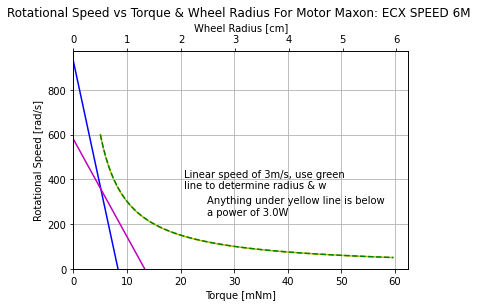

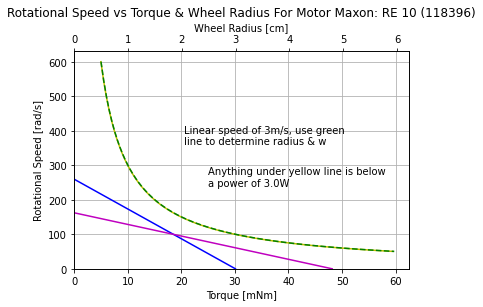

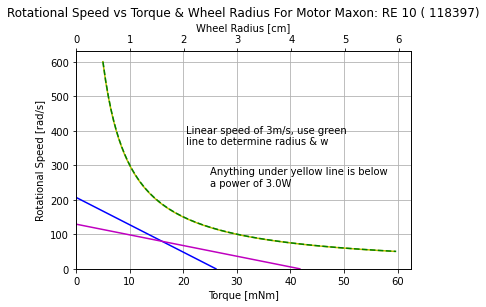

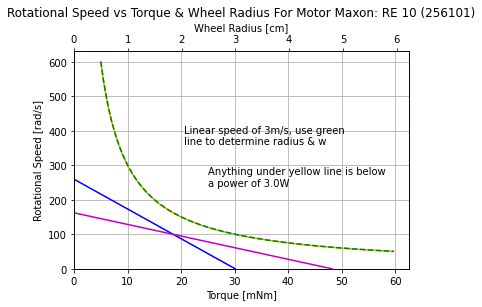

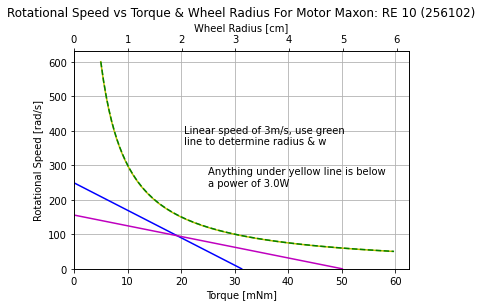

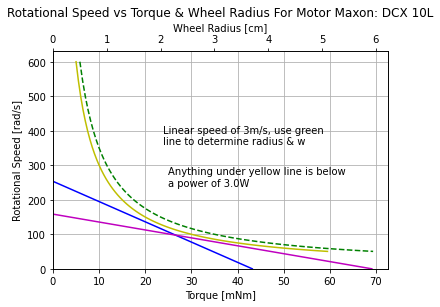

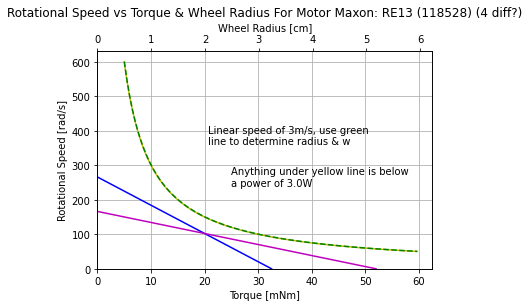

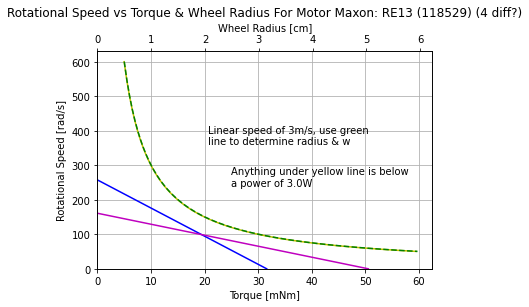

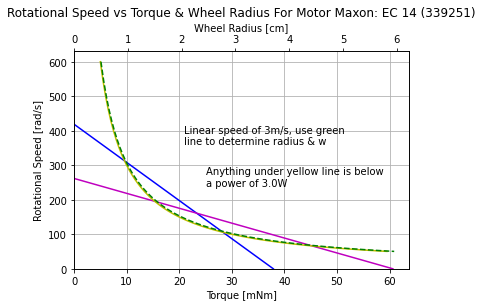

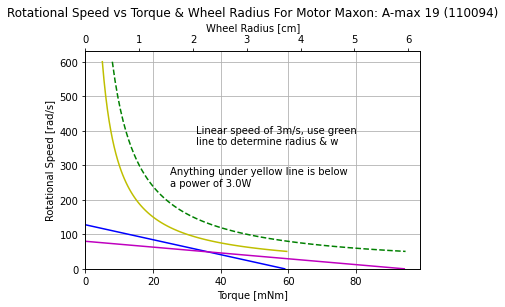

In [12]:
# For 1.5W Motors

for i in range(10):
    a_motor = 10
    F_motor = m_kg*a_motor

    wheel_radii = np.arange(.5, 6, 0.05)

    diff_torques = []
    omega_rad = []

    for rad in wheel_radii:
        omega = v_max / (rad / 100)
        omega_rad.append(omega)

        t = F_motor*(rad / 100)
        diff_torques.append(t*1000)

        if (t*1000) > 14.5 and (t*1000) < 15.5:
            mark_pt = [t*1000, rad]
    
    no_load_w = (2*math.pi*all_motor_no_load_RPM[i]) / 60
    motor_stall_t = all_motor_stall_t[i]*2

    P_MAX1 = motor_power*2
    w_max1 = []

    for tor in diff_torques:
        w = P_MAX1 / (tor / 1000)
        w_max1.append(w)

    GEAR_RATIO1 = 5
    GEAR_RATIO2 = 8

    fig, ax1 = plt.subplots()
    ax1.plot([0, motor_stall_t*GEAR_RATIO1], [no_load_w/GEAR_RATIO1, 0], '-b') #torque speed with a gear ratio
    ax1.plot([0, motor_stall_t*GEAR_RATIO2], [no_load_w/GEAR_RATIO2, 0], '-m') #torque speed with a gear ratio
    ax1.plot(diff_torques, w_max1, '-y')
    ax1.set_xlabel('Torque [mNm]')
    ax1.set_ylabel('Rotational Speed [rad/s]')
    ax1.grid(b=None, which='both', axis='both')
    ax1.text(25, 240, f"Anything under yellow line is below \na power of {P_MAX1}W")
    ax1.set_ylim(bottom= 0)
    ax1.set_xlim(left= 0)

    ax2 = ax1.twiny()
    ax2.plot(wheel_radii, omega_rad, '--g')
    ax2.set_xlim(left= 0)
    ax2.grid(b=None, which='both', axis='both')
    ax2.set_xlabel('Wheel Radius [cm]')
    ax2.text(2.05, 360, f"Linear speed of {v_max}m/s, use green \nline to determine radius & w")

    plt.title(f'Rotational Speed vs Torque & Wheel Radius For Motor {all_motor_name[i]}')
    plt.grid(b=None, which='both', axis='both')
    plt.show()

The space below the yellow curve on the Speed-Torque graph are the speed and torque combos that keep the power under 1.5W (each motor is rated for 3W, so combined they have a max power of 3W). The green line represents the angular speed vs wheel radius relationship needed to maintain a linear speed of 3m/s. Any radius-speed combo that intersects the green line produces a linear speed of 3m/s. Combinations above that line warrant a higher linear speed while any pairing below it will produce less than 3m/s. 

Ideally, we want the yellow line to intersect somewhere on the Speed-Torque curve since this means that we can achieve a combined power of 3W. If the yellow line doesnt intersect any Speed-Torque curves, I can assume those motor do not have the power output we need. 

Given that, the only 1.5W motor that might work would be the EC14 Maxon motors. 

<!-- For 1.5W, thats index 8 -->

In [13]:
# FOR 2W MOTORS #
motor_name = [] 
nominal_V = []
nominal_A = [] 
single_motor_weight= [] 
motor_no_load_RPM = [] 
motor_max_t = [] 
motor_stall_t= [] 
motor_R = [] 
motor_kt = [] 
motor_eff = []
motor_diam = []


def read_csv(filename):
    with open(filename) as f:
        # open the csv file
        reader = csv.reader(f)
        for row in reader:
            # read the rows 1 one by one
            motor_name.append(str(row[0]))
            nominal_V.append(float(row[1]))
            nominal_A.append(float(row[2]))
            single_motor_weight.append(float(row[3]))
            motor_no_load_RPM.append(float(row[4]))
            motor_max_t.append(float(row[5]))
            motor_stall_t.append(float(row[6]))
            motor_R.append(float(row[7]))
            motor_kt.append(float(row[8]))
            motor_eff.append(float(row[9]))
            motor_diam.append(float(row[10]))
            
    return motor_name, nominal_V, nominal_A, single_motor_weight, motor_no_load_RPM, motor_max_t, motor_stall_t, motor_R, motor_kt, motor_eff, motor_diam

filename = "2W_motors_v2.csv"
motor_power = 2
all_motor_name, all_nominal_V, all_nominal_A, all_single_motor_weight, all_motor_no_load_RPM, all_motor_max_t, all_motor_stall_t, all_motor_R, all_motor_kt, all_motor_eff, all_motor_diam = read_csv(filename)

print(f""" Names: {all_motor_name}\n
      Voltages: {all_nominal_V}\n
      Amps: {all_nominal_A}\n
      Weights: {all_single_motor_weight}\n
      w0: {all_motor_no_load_RPM}\n
      Max torque: {all_motor_max_t}\n
      Stall Torque:{all_motor_stall_t}\n
      Motor Resistance: {all_motor_R}\n
      Torque Constant: {all_motor_kt}\n
      Effciency: {all_motor_eff}\n
      Diameter: {all_motor_diam}""")

M6_index = 0

M6_name = all_motor_name[M6_index]
M6_V = all_nominal_V[M6_index]
M6_A = all_nominal_A[M6_index]
M6_g = all_single_motor_weight[M6_index]
M6_w0 = all_motor_no_load_RPM[M6_index]
M6_max_t = all_motor_max_t[M6_index]
M6_stall_t = all_motor_stall_t[M6_index]
M6_R = all_motor_R[M6_index]
M6_kt = all_motor_kt[M6_index]
M6_eff = all_motor_eff[M6_index]
M6_d = all_motor_diam[M6_index]


M8_index = 1

M8_name = all_motor_name[M8_index]
M8_V = all_nominal_V[M8_index]
M8_A = all_nominal_A[M8_index]
M8_g = all_single_motor_weight[M8_index]
M8_w0 = all_motor_no_load_RPM[M8_index]
M8_max_t = all_motor_max_t[M8_index]
M8_stall_t = all_motor_stall_t[M8_index]
M8_R = all_motor_R[M8_index]
M8_kt = all_motor_kt[M8_index]
M8_eff = all_motor_eff[M8_index]
M8_d = all_motor_diam[M8_index]

 Names: ['Maxon: SPEED 6 M ', 'Maxon: SPEED 8 M', 'Maxon: RE13 (118500)', 'Maxon: RE13 (118501)', 'Maxon: RE 16 (320175)', 'Maxon: A-max 16 (110073) (6 options?)', 'Maxon: DC-max 16 (brushed)']

      Voltages: [6.0, 6.0, 6.0, 7.2, 6.0, 6.0, 6.0]

      Amps: [0.517, 0.687, 0.367, 0.294, 0.365, 0.495, 0.575]

      Weights: [3.0, 6.0, 21.0, 21.0, 21.0, 22.0, 23.0]

      w0: [62700.0, 35400.0, 6810.0, 6590.0, 7960.0, 9360.0, 7890.0]

      Max torque: [0.412, 0.917, 2.95, 2.95, 2.54, 2.42, 4.04]

      Stall Torque:[1.52, 3.04, 5.49, 5.26, 5.92, 4.05, 10.5]

      Motor Resistance: [3.49, 3.02, 9.03, 14.0, 7.2, 8.25, 4.1]

      Torque Constant: [0.882, 1.53, 8.92, 10.91, 7.68, 6.12, 7.91]

      Effciency: [0.67, 0.6, 0.76, 0.75, 0.8, 0.75, 0.81]

      Diameter: [6.0, 8.0, 13.0, 13.0, 16.0, 16.0, 16.0]


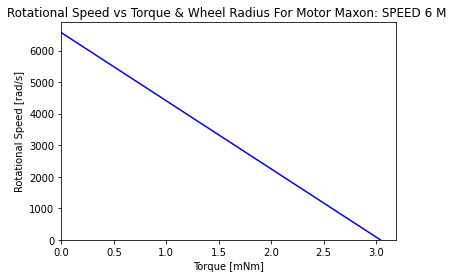

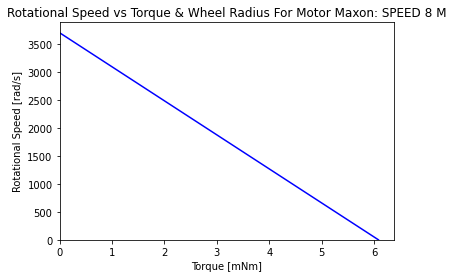

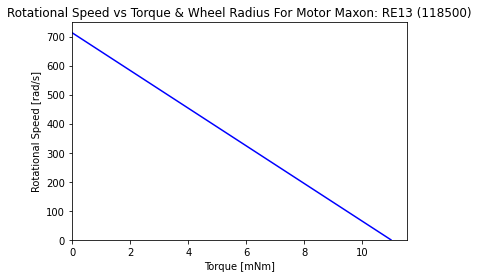

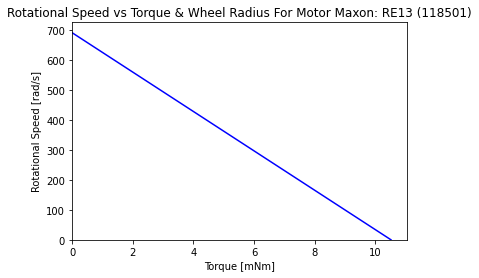

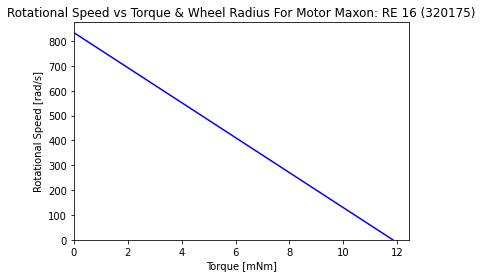

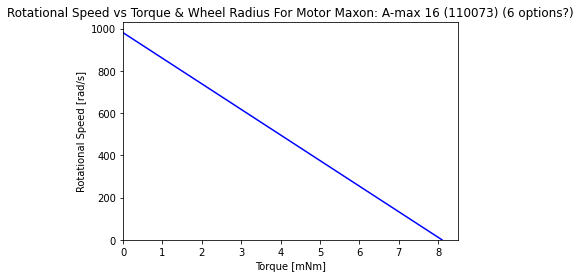

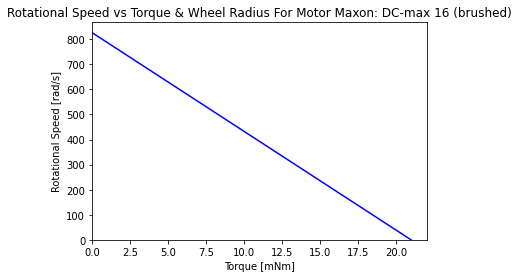

In [89]:
# For 2W Motors

for i in range(7):
    a_motor = 10
    F_motor = m_kg*a_motor

    wheel_radii = np.arange(.5, 6, 0.05)

    diff_torques = []
    omega_rad = []

    for rad in wheel_radii:
        omega = v_max / (rad / 100)
        omega_rad.append(omega)

        t = F_motor*(rad / 100)
        diff_torques.append(t*1000)

        if (t*1000) > 14.5 and (t*1000) < 15.5:
            mark_pt = [t*1000, rad]
    
    no_load_w = (2*math.pi*all_motor_no_load_RPM[i]) / 60
    motor_stall_t = all_motor_stall_t[i]*2

    P_MAX2 = motor_power*2
    w_max2 = []

    for tor in diff_torques:
        w = P_MAX2 / (tor / 1000)
        w_max2.append(w)

    GEAR_RATIO1 = 6
    GEAR_RATIO2 = 8

    fig, ax1 = plt.subplots()
    ax1.plot([0, motor_stall_t], [no_load_w, 0], '-b') #torque speed with a gear ratio
#     ax1.plot([0, motor_stall_t*GEAR_RATIO1], [no_load_w/GEAR_RATIO1, 0], '-b') #torque speed with a gear ratio
#     ax1.plot([0, motor_stall_t*GEAR_RATIO2], [no_load_w/GEAR_RATIO2, 0], '-m') #torque speed with a gear ratio
#     ax1.plot(diff_torques, w_max2, '-y')
    ax1.set_xlabel('Torque [mNm]')
    ax1.set_ylabel('Rotational Speed [rad/s]')
    ax1.grid(b=None, which='both', axis='both')
#     ax1.text(25, 240, f"Anything under yellow line is below \na power of {P_MAX2}W")
    ax1.set_ylim(bottom= 0)
    ax1.set_xlim(left= 0)

#     ax2 = ax1.twiny()
# #     ax2.plot(wheel_radii, omega_rad, '--g')
#     ax2.set_xlim(left= 0)
#     ax2.grid(b=None, which='both', axis='both')
#     ax2.set_xlabel('Wheel Radius [cm]')
# #     ax2.text(2.05, 360, f"Linear speed of {v_max}m/s, use green \nline to determine radius & w")

    plt.title(f'Rotational Speed vs Torque & Wheel Radius For Motor {all_motor_name[i]}')
    plt.grid(b=None, which='both', axis='both')
    plt.show()

The space below the yellow curve on the Speed-Torque graph are the speed and torque combos that keep the power under 2W (each motor is rated for 4W, so combined they have a max power of 4W). The green line represents the angular speed vs wheel radius relationship needed to maintain a linear speed of 3m/s. Any radius-speed combo that intersects the green line produces a linear speed of 3m/s. Combinations above that line warrant a higher linear speed while any pairing below it will produce less than 3m/s. 

Ideally, we want the yellow line to intersect somewhere on the Speed-Torque curve since this means that we can achieve a combined power of 4W. If the yellow line doesnt intersect any Speed-Torque curves, I can assume those motor do not have the power output we need. 

Given that, the only 2W motors that might work would be the Maxon SPEED 6M and SPEED 8M. 

<!-- For 2W, thats index 0 and 1 -->

In [15]:
# # FOR 2.5w MOTORS ##
# motor_name = [] 
# nominal_V = []
# nominal_A = [] 
# single_motor_weight= [] 
# motor_no_load_RPM = [] 
# motor_max_t = [] 
# motor_stall_t= [] 
# motor_R = [] 
# motor_kt = [] 
# motor_eff = []
# motor_diam = []


# def read_csv(filename):
#     with open(filename) as f:
#         # open the csv file
#         reader = csv.reader(f)
#         for row in reader:
#             # read the rows 1 one by one
#             motor_name.append(str(row[0]))
#             nominal_V.append(float(row[1]))
#             nominal_A.append(float(row[2]))
#             single_motor_weight.append(float(row[3]))
#             motor_no_load_RPM.append(float(row[4]))
#             motor_max_t.append(float(row[5]))
#             motor_stall_t.append(float(row[6]))
#             motor_R.append(float(row[7]))
#             motor_kt.append(float(row[8]))
#             motor_eff.append(float(row[9]))
#             motor_diam.append(float(row[10]))
            
#     return motor_name, nominal_V, nominal_A, single_motor_weight, motor_no_load_RPM, motor_max_t, motor_stall_t, motor_R, motor_kt, motor_eff, motor_diam

# filename = "2.5W_motors_v2.csv"
# motor_power = 2.5
# all_motor_name, all_nominal_V, all_nominal_A, all_single_motor_weight, all_motor_no_load_RPM, all_motor_max_t, all_motor_stall_t, all_motor_R, all_motor_kt, all_motor_eff, all_motor_diam = read_csv(filename)

# print(f""" Names: {all_motor_name}\n
#       Voltages: {all_nominal_V}\n
#       Amps: {all_nominal_A}\n
#       Weights: {all_single_motor_weight}\n
#       w0: {all_motor_no_load_RPM}\n
#       Max torque: {all_motor_max_t}\n
#       Stall Torque:{all_motor_stall_t}\n
#       Motor Resistance: {all_motor_R}\n
#       Torque Constant: {all_motor_kt}\n
#       Effciency: {all_motor_eff}\n
#       Diameter: {all_motor_diam}""")


# # EC_index = 8

# # EC_name = all_motor_name[EC_index]
# # EC_V = all_nominal_V[EC_index]
# # EC_A = all_nominal_A[EC_index]
# # EC_g = all_single_motor_weight[EC_index]
# # EC_w0 = all_motor_no_load_RPM[EC_index]
# # EC_max_t = all_motor_max_t[EC_index]
# # EC_stall_t = all_motor_stall_t[EC_index]
# # EC_R = all_motor_R[EC_index]
# # EC_kt = all_motor_kt[EC_index]
# # EC_eff = all_motor_eff[EC_index]
# # EC_d = all_motor_diam[EC_index]

In [16]:
# # For 2.5W Motors

# for i in range(6):
#     a_motor = 10
#     F_motor = m_kg*a_motor

#     wheel_radii = np.arange(.75, 6, 0.05)

#     diff_torques = []
#     omega_rad = []

#     for rad in wheel_radii:
#         omega = v_max / (rad / 100)
#         omega_rad.append(omega)

#         t = F_motor*(rad / 100)
#         diff_torques.append(t*1000)

#         if (t*1000) > 14.5 and (t*1000) < 15.5:
#             mark_pt = [t*1000, rad]


# #     no_load_w = (2*math.pi*motor_no_load_RPM) / 60
# #     motor_stall_t = motor_stall_t*2
    
#     no_load_w = (2*math.pi*all_motor_no_load_RPM[i]) / 60
#     motor_stall_t = all_motor_stall_t[i]*2

# #     P_MAX1 = motor_power*2
#     w_max1 = []

#     for tor in diff_torques:
#         w = P_MAX1 / (tor / 1000)
#         w_max1.append(w)

#     GEAR_RATIO1 = 1
#     GEAR_RATIO2 = 2

#     fig, ax1 = plt.subplots()
# #     ax1.plot([0, motor_stall_t], [no_load_w, 0]) #original torque speed line
#     ax1.plot([0, motor_stall_t*GEAR_RATIO1], [no_load_w/GEAR_RATIO1, 0], '-b') #torque speed with a gear ratio
#     ax1.plot([0, motor_stall_t*GEAR_RATIO2], [no_load_w/GEAR_RATIO2, 0], '-m') #torque speed with a gear ratio
#     ax1.plot(diff_torques, w_max1, '-y')
#     ax1.set_xlabel('Torque [mNm]')
#     ax1.set_ylabel('Rotational Speed [rad/s]')
#     ax1.grid(b=None, which='both', axis='both')
#     ax1.text(25, 240, f"Anything under yellow line is below \na power of {P_MAX1}W")
#     ax1.set_ylim(bottom= 0)
#     ax1.set_xlim(left= 0)

#     ax2 = ax1.twiny()
#     ax2.plot(wheel_radii, omega_rad, '--g')
#     ax2.set_xlim(left= 0)
#     ax2.grid(b=None, which='both', axis='both')
#     ax2.set_xlabel('Wheel Radius [cm]')
#     ax2.text(2.05, 360, f"Linear speed of {v_max}m/s, use green \nline to determine radius & w")

#     plt.title(f'Rotational Speed vs Torque & Wheel Radius For Motor {all_motor_name[i]}')
#     plt.grid(b=None, which='both', axis='both')
#     plt.show()

In [17]:
# # FOR 3W MOTORS
# motor_name = [] 
# nominal_V = []
# nominal_A = [] 
# single_motor_weight= [] 
# motor_no_load_RPM = [] 
# motor_max_t = [] 
# motor_stall_t= [] 
# motor_R = [] 
# motor_kt = [] 
# motor_eff = []
# motor_diam = []


# def read_csv(filename):
#     with open(filename) as f:
#         # open the csv file
#         reader = csv.reader(f)
#         for row in reader:
#             # read the rows 1 one by one
#             motor_name.append(str(row[0]))
#             nominal_V.append(float(row[1]))
#             nominal_A.append(float(row[2]))
#             single_motor_weight.append(float(row[3]))
#             motor_no_load_RPM.append(float(row[4]))
#             motor_max_t.append(float(row[5]))
#             motor_stall_t.append(float(row[6]))
#             motor_R.append(float(row[7]))
#             motor_kt.append(float(row[8]))
#             motor_eff.append(float(row[9]))
#             motor_diam.append(float(row[10]))
            
#     return motor_name, nominal_V, nominal_A, single_motor_weight, motor_no_load_RPM, motor_max_t, motor_stall_t, motor_R, motor_kt, motor_eff, motor_diam

# filename = "3W_motors_v2.csv"
# motor_power = 3
# all_motor_name, all_nominal_V, all_nominal_A, all_single_motor_weight, all_motor_no_load_RPM, all_motor_max_t, all_motor_stall_t, all_motor_R, all_motor_kt, all_motor_eff, all_motor_diam = read_csv(filename)

# print(f""" Names: {all_motor_name}\n
#       Voltages: {all_nominal_V}\n
#       Amps: {all_nominal_A}\n
#       Weights: {all_single_motor_weight}\n
#       w0: {all_motor_no_load_RPM}\n
#       Max torque: {all_motor_max_t}\n
#       Stall Torque:{all_motor_stall_t}\n
#       Motor Resistance: {all_motor_R}\n
#       Torque Constant: {all_motor_kt}\n
#       Effciency: {all_motor_eff}\n
#       Diameter: {all_motor_diam}""")

In [18]:
# # For 3W Motors

# for i in range(6):
#     a_motor = 10
#     F_motor = m_kg*a_motor

#     wheel_radii = np.arange(.75, 6, 0.05)

#     diff_torques = []
#     omega_rad = []

#     for rad in wheel_radii:
#         omega = v_max / (rad / 100)
#         omega_rad.append(omega)

#         t = F_motor*(rad / 100)
#         diff_torques.append(t*1000)

#         if (t*1000) > 14.5 and (t*1000) < 15.5:
#             mark_pt = [t*1000, rad]
    
#     no_load_w = (2*math.pi*all_motor_no_load_RPM[i]) / 60
#     motor_stall_t = all_motor_stall_t[i]*2

# #     P_MAX1 = motor_power*2
#     w_max1 = []

#     for tor in diff_torques:
#         w = P_MAX1 / (tor / 1000)
#         w_max1.append(w)

#     GEAR_RATIO1 = 1
#     GEAR_RATIO2 = 2

#     fig, ax1 = plt.subplots()
# #     ax1.plot([0, motor_stall_t], [no_load_w, 0]) #original torque speed line
#     ax1.plot([0, motor_stall_t*GEAR_RATIO1], [no_load_w/GEAR_RATIO1, 0], '-b') #torque speed with a gear ratio
#     ax1.plot([0, motor_stall_t*GEAR_RATIO2], [no_load_w/GEAR_RATIO2, 0], '-m') #torque speed with a gear ratio
#     ax1.plot(diff_torques, w_max1, '-y')
#     ax1.set_xlabel('Torque [mNm]')
#     ax1.set_ylabel('Rotational Speed [rad/s]')
#     ax1.grid(b=None, which='both', axis='both')
#     ax1.text(25, 340, f"Anything under yellow line is below \na power of {P_MAX1}W")
#     ax1.set_ylim(bottom= 0)
#     ax1.set_xlim(left= 0)

#     ax2 = ax1.twiny()
#     ax2.plot(wheel_radii, omega_rad, '--g')
#     ax2.set_xlim(left= 0)
#     ax2.grid(b=None, which='both', axis='both')
#     ax2.set_xlabel('Wheel Radius [cm]')
#     ax2.text(2.05, 760, f"Linear speed of {v_max}m/s, use green \nline to determine radius & w")

#     plt.title(f'Rotational Speed vs Torque & Wheel Radius For Motor {all_motor_name[i]}')
#     plt.grid(b=None, which='both', axis='both')
#     plt.show()

## From Mechanical to Electrical

So far we've looked at a lot of mechanical motor reqirements, but how does that relate to the electrical specs? Lets investigate the power input, aka the electrical power. 

On the surface, P input is...

$P_e = IV$

*Where I is current and V is Votlage*

However, this input Power has to account for the Mechanical Power ($\tau\omega$) as well as power lost through heat dissipation and such. Therefore...

$IV = \tau\omega + {I}^2 R + LI \frac{dI}{dt}$

Dividing by $I$ we can get an equation for the Voltage:

$V = \frac{\tau}{I} \omega + IR + L \frac{dI}{dt}$


$\frac{\tau}{I}$ is a constant value, given Lorentz force law. This constant is called the torque constant $k_t$

$k_t = \frac{\tau}{I}$

$\tau = k_t I$

Rewrite the Voltage equation to incorparate the torqu constant...

$V = k_t \omega + IR + L \frac{dI}{dt}$

Going back to the Speed-Torque curve, we can assume that at a constant speed and constant torque the Voltage equation is reduced to...

$V = k_t \omega + IR $

Solving for $\omega$ ...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Here, we can calculate the no load speed and stall torque given the electrical specs of the motor

$\omega_0 = \frac{V}{k_t}$

$\tau_s = \frac{k_t V}{R}$

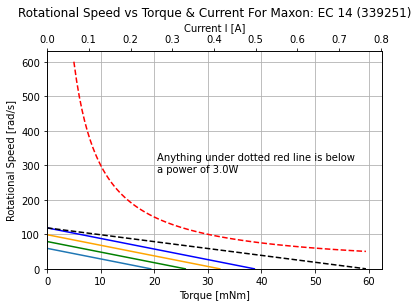

In [19]:
# For EC14 
# print(f""" Names: {EC_name}\n
#       Voltages: {EC_V}\n
#       Amps: {EC_A}\n
#       Weights: {EC_g}\n
#       w0: {EC_w0}\n
#       Max torque: {EC_max_t}\n
#       Stall Torque:{EC_stall_t}\n
#       Motor Resistance: {EC_R}\n
#       Torque Constant: {EC_kt}\n
#       Effciency: {EC_eff}\n
#       Diameter: {EC_d}""")

EC_kt = EC_kt / 1000

w0_elec1_EC = EC_V / EC_kt
ts_elec1_EC = ((EC_kt*EC_V)/EC_R) * 1000 * 2 #Multiple by 3 for two motors

# P_3W = 3
# w_3W = []

# for tor in diff_torques:
#     w3 = P_3W / (tor / 1000)
#     w_3W.append(w3)

fig, ax7 = plt.subplots()
ax7.plot([0, ts_elec1_EC*10], [w0_elec1_EC / 10, 0], "blue") #original torque speed line
ax7.plot([0, ts_elec1_EC*10*(5/6)], [w0_elec1_EC*(5/6) / 10, 0], "orange") #original torque speed line
ax7.plot([0, ts_elec1_EC*10*(4/6)], [w0_elec1_EC*(4/6) / 10, 0], "green") #original torque speed line
ax7.plot([0, ts_elec1_EC*10*(3/6)], [w0_elec1_EC*(3/6) / 10, 0]) #original torque speed line
ax7.set_xlabel('Torque [mNm]')
ax7.set_ylabel('Rotational Speed [rad/s]')
ax7.plot(diff_torques, w_max1, '--', color='red')
ax7.text(20.5, 280, f"Anything under dotted red line is below \na power of {P_MAX1}W")
ax7.set_ylim(bottom= 0)
ax7.set_xlim(left= 0)
ax7.grid(b=None, which='both', axis='both')

ax8 = ax7.twiny()
ax8.plot([0, (ts_elec1_EC/1000)/EC_kt], [w0_elec1_EC/10, 0], "--", color="black") #original torque speed line
# ax8.plot(wheel_radii, omega_rad, "darkorchid")
ax8.set_xlabel('Current I [A]')
ax8.set_xlim(left= 0)

plt.title(f'Rotational Speed vs Torque & Current For {EC_name}')
plt.show()

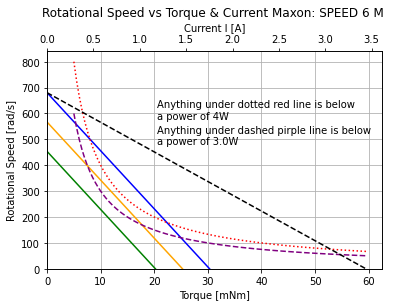

In [20]:
# For 6M
# print(f""" Names: {M6_name}\n
#       Voltages: {M6_V}\n
#       Amps: {M6_A}\n
#       Weights: {M6_g}\n
#       w0: {M6_w0}\n
#       Max torque: {M6_max_t}\n
#       Stall Torque:{M6_stall_t}\n
#       Motor Resistance: {M6_R}\n
#       Torque Constant: {M6_kt}\n
#       Effciency: {M6_eff}\n
#       Diameter: {M6_d}""")

M6_kt = M6_kt / 1000

w0_elec1_M6 = M6_V / M6_kt
ts_elec1_M6 = ((M6_kt*M6_V)/M6_R) * 1000 * 2 #Multiply by 2 for two motors

# P_4W = 4
# w_4W = []

# for tor in diff_torques:
#     w4 = P_4W / (tor / 1000)
#     w_4W.append(w4)

fig, ax70 = plt.subplots()
ax70.plot([0, ts_elec1_M6*10], [w0_elec1_M6/ 10, 0], "blue") #original torque speed line
ax70.plot([0, ts_elec1_M6*10*(5/6)], [w0_elec1_M6*(5/6) / 10, 0], "orange") #original torque speed line
ax70.plot([0, ts_elec1_M6*10*(4/6)], [w0_elec1_M6*(4/6) / 10, 0], "green") #original torque speed line
ax70.set_xlabel('Torque [mNm]')
ax70.set_ylabel('Rotational Speed [rad/s]')
ax70.plot(diff_torques, w_max2, ':', color='red')
ax70.plot(diff_torques, w_max1, '--', color='purple')
ax70.text(20.5, 580, f"Anything under dotted red line is below \na power of {P_MAX2}W")
ax70.text(20.5, 480, f"Anything under dashed pirple line is below \na power of {P_MAX1}W")
ax70.set_ylim(bottom= 0)
ax70.set_xlim(left= 0)
ax70.grid(b=None, which='both', axis='both')

ax80 = ax70.twiny()
ax80.plot([0, (ts_elec1_M6/1000)/M6_kt], [w0_elec1_M6/10, 0], "--", color="black") #original torque speed line
# ax80.plot(wheel_radii, omega_rad, "darkorchid")
ax80.set_xlabel('Current I [A]')
ax80.set_xlim(left= 0)

plt.title(f'Rotational Speed vs Torque & Current {M6_name}')
plt.show()

Given stall t is 6.08 but we calculate for the motor that stall torque is 6.079470198675497


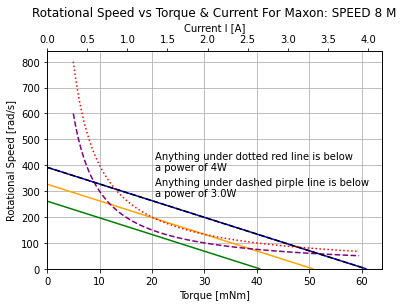

In [21]:
# For 8M
# print(f""" Names: {M8_name}\n
#       Voltages: {M8_V}\n
#       Amps: {M8_A}\n
#       Weights: {M8_g}\n
#       w0: {M8_w0}\n
#       Max torque: {M8_max_t}\n
#       Stall Torque:{M8_stall_t}\n
#       Motor Resistance: {M8_R}\n
#       Torque Constant: {M8_kt}\n
#       Effciency: {M8_eff}\n
#       Diameter: {M8_d}""")

M8_kt = M8_kt / 1000

w0_elec1_M8 = M8_V / M8_kt
ts_elec1_M8 = ((M8_kt*M8_V)/M8_R) * 1000 * 2 #Multiply by 2 for two motors

print(f"Given stall t is {M8_stall_t*2} but we calculate for the motor that stall torque is {ts_elec1_M8}")

fig, ax71 = plt.subplots()
ax71.plot([0, ts_elec1_M8*10], [w0_elec1_M8 / 10, 0], "blue") #original torque speed line
ax71.plot([0, ts_elec1_M8*10*(5/6)], [w0_elec1_M8*(5/6) / 10, 0], "orange") #original torque speed line
ax71.plot([0, ts_elec1_M8*10*(4/6)], [w0_elec1_M8*(4/6) / 10, 0], "green") #original torque speed line
ax71.set_xlabel('Torque [mNm]')
ax71.set_ylabel('Rotational Speed [rad/s]')
ax71.plot(diff_torques, w_max2, ':', color='red')
ax71.plot(diff_torques, w_max1, '--', color='purple')
ax71.text(20.5, 380, f"Anything under dotted red line is below \na power of {P_MAX2}W")
ax71.text(20.5, 280, f"Anything under dashed pirple line is below \na power of {P_MAX1}W")
ax71.set_ylim(bottom= 0)
ax71.set_xlim(left= 0)
ax71.grid(b=None, which='both', axis='both')

ax81= ax71.twiny()
ax81.plot([0, (ts_elec1_M8/1000)/M8_kt], [w0_elec1_M8/10, 0], "--",  color="black") #original torque speed line
# ax81.plot(wheel_radii, omega_rad, "darkorchid")
ax81.set_xlabel('Current I [A]')
ax81.set_xlim(left= 0)

plt.title(f'Rotational Speed vs Torque & Current For {M8_name}')
plt.show()

In the graph above, the blue line represents 6V, the orange is 5V, and the green is 4V. 

<!-- When you compare this graph to the Rotational Speed vs Wheel Radius before, you see that in order to maintain the linear speed we would like, we are going to be operating above 4V and below 6V, with currents between 0.75A - 3A. While the max current is around 3A, we'd only be drawing that much for high torques. Resonably we'll probably be somewhere between 0.75A and 2A. 

Given the battery calcuations I did at the top of the page, for 15 minutes we can use around 3.8A total. Assuming we use 2A for the motor, that leaves 1.8A left for the other electrical equipment. **Is that enough?** -->

<!-- **Okay, mechanically this seems pretty reasonable. We have a mass of 0.1kg, a max desired velocity of 3m/s, a constant accleration of 10m/s, and a combined motor power up to 4W. I think a gear ratio of 1:10 works out great and we can resonable use wheel radii bewteen 1 and 4cm**

## Lets do some simulations

Use some basic kinematic equations to "simulate" the robot's motion

$x_f = x_0 + v_a t$ 

$v_f = v_0 + at$

$x_f = x_0 + v_0 t + \frac{1}{2} a{t}^2$

${v_f}^2 = {v_0}^2 + 2a\Delta x$


*where $v_a$ is the average velocity and we assume $v_0$ = 0* -->

In [22]:
# time = np.arange(0, 1.1, 0.01)
# dist1 = []
# dist2 = []
# vel1 = []
# vel2 = []
# accel =[]

# for t in time:
#     x_f1 = 0 + (v_max)*t
#     x_f2 = 0 + 0 + (0.5*a_motor)*(t*t)
#     dist1.append(x_f1)
#     dist2.append(x_f2)
    
#     v_f1 = a_motor*t
#     v_f2 = math.sqrt(2*a_motor*x_f1)
#     vel1.append(v_f1)
#     vel2.append(v_f2)

In [23]:
# fig, ax3 = plt.subplots()
# ax3.plot(time, dist1, '-b')
# ax3.plot(time, dist2, '-m')
# ax3.set_xlabel('Time [s]')
# ax3.set_ylabel('Disatamce Traveled [m]')
# ax3.grid(b=None, which='both', axis='both')
# ax3.text(0.01, 3.1, "Blue line: Dist based on ave vel \nMagenta line: Dist based on const accel")
# ax3.set_ylim(bottom= 0, top = 4)
# ax3.set_xlim(left= 0)

# fig, ax4 = plt.subplots()
# ax4.plot(time, vel1, '-g')
# ax4.plot(time, vel2, '-y')
# # ax4.plot(time, vel3, '-b')
# ax4.set_xlabel('Time [s]')
# ax4.set_ylabel('Velocity [m/s]')
# ax4.grid(b=None, which='both', axis='both')
# ax4.text(0.01, 8.5, "Green line: Vel based on accel only \nYellow line: Vel based on accel and dist traveled")
# ax4.set_ylim(bottom= 0)
# ax4.set_xlim(left= 0)


# I thought it might be helpful to see all the information together, but its just kinda confusing...
# fig, ax5 = plt.subplots()
# ax5.plot(time, dist1, '-b')
# ax5.plot(time, dist2, '-m')
# ax5.set_xlabel('Time [s]')
# ax5.set_ylabel('Disatamce Traveled [m]')
# ax5.grid(b=None, which='both', axis='both')
# ax5.set_ylim(bottom= 0, top = 4)
# ax5.set_xlim(left= 0)

# ax6 = ax5.twinx()
# ax6.plot(time, vel1, '-g')
# ax6.plot(time, vel2, '-y')
# ax6.set_ylim(bottom = 0, top = 8)
# # ax6.grid(b=None, which='both', axis='both')
# ax6.set_ylabel('Velocity [m/s]')

These all assume we're operating at 6V. I should test different voltage and current combos

## ACTUAL Simualtions (assuming varible acceleration and velocity?)

For the graphs above, I was assuming a bunch of constant / average values. I.e. and ave acceleration of 10 $m/{s}^2$, which meant a constant torque value. Now we want to solve for positional / simualtion ("trajectory") data assuming that we dont have constant / average values. 


Given the electrical input power equations above, we solved for $\omega$ given a motor's torque constant, voltage and resistance...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Now lets rearrange this equation to solve for torque:

$\omega - \frac{1}{k_t} V = - \frac{R}{{k_t}^2} \tau$

$\frac{R}{{k_t}^2} \tau = \frac{1}{k_t} V - \omega$

$R \tau = V k_t - \omega {k_t}^2$

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

Assuming a 100% effiecent motor, we can use these mechanical eqautions...

$F = ma$

$\tau = Fr = mar$

$v = \omega r$

$\omega = \frac{v}{r}$


Sub the appropriate equations into $\tau$ and $\omega$...

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

$mar = \frac{V k_t - \frac{v}{r} {k_t}^2}{R} = \frac{V k_t}{R} - \frac{v {k_t}^2}{Rr}$

$a = \frac{V k_t}{Rmr} - \frac{v {k_t}^2}{Rm{r}^2}$

$0 = a + \frac{v {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} $


NOOWWWW lets make it a differential. Cause why not?

$\frac{{d}^2 x}{d{t}^2} + \frac{\frac{dx}{dt} {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} = 0$


Solve for:

$\frac{{d}^2 x}{d{t}^2} + \frac{{k_t}^2 \frac{dx}{dt}}{Rm{r}^2} = 0$


Assume the solution will be porpoertional to ${e}^{\lambda t}$ and sub $x(t)= {e}^{\lambda t}$ into the diff eq:

$\frac{{d}^2}{d{t}^2} {e}^{\lambda t} + \frac{{k_t}^2 \frac{d}{dt} {e}^{\lambda t}}{Rm{r}^2} = 0$

${\lambda}^2 {e}^{\lambda t} + \frac{{k_t}^2 \lambda {e}^{\lambda t}}{Rm{r}^2} = 0$

$({\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2}) {e}^{\lambda t} = 0$


Since ${e}^{\lambda t}$ CANNOT equal 0...

${\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2} = 0$

$\frac{\lambda ({k_t}^2 + \lambda Rm{r}^2)}{Rm{r}^2} = 0$


Solving for $\lambda$....

$\lambda = 0$

and

$\lambda = - \frac{{k_t}^2}{Rm{r}^2}$


For complementary solutions a root of $\lambda = 0$ gives $x_1(t) = c_1$

Also a root $\lambda = - \frac{{k_t}^2}{Rm{r}^2}$ gives $x_2(t) = c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$

Therefore the general solution is 

$x(t) = x_1 (t) + x_2 (t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$


Great! Now determine the particular solution by the method of undetermined coefficients where $x_p(t) = a_1 t$:

$\frac{dx_p(t)}{dt} = \frac{d}{dt}(a_1 t) = a_1$

$\frac{{d}^2 x_p(t)}{d{t}^2} = \frac{{d}^2}{d{t}^2} (a_1 t) = 0$

$\frac{{d}^2 x_p (t)}{d{t}^2} + \frac{{k_t}^2 \frac{d x_p (t)}{dt}}{Rm{r}^2} = \frac{k_t V}{R m r}$

$\frac{{k}^2 a_1}{Rm{r}^2} = \frac{k_t V}{Rmr}$

$a_1 = \frac{rV}{k_t}$

$x_p(t) = \frac{rVt}{k_t}$


Making the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$


Now lets solve with our givens $x(0) = 0$ and $\frac{dx}{dt}(0) = 0$. For t = 0 and x(0) = 0...

$c_1 + c_2 = 0$


Taking the derivative of our general solution we get:

$\frac{dx(t)}{dt} = \frac{rV}{k} - \frac{{k_t}^2 c_2 e^{-\frac{{k_t}^2 t}{Rm{r}^2}}}{Rm{r}^2}$


Subbing in $\frac{dx}{dt}(0) = 0$ for t = 0...

$\frac{rV}{k} - \frac{{k}^2 c_2}{Rm{r}^2} = 0$

$c_2 = \frac{Vm {r}^3 R}{{k}^3}$


Which means...

$c_1 = - \frac{Vm {r}^3 R}{{k}^3}$


Plugging the constants into the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = - \frac{Vm {r}^3 R}{{k}^3} + \frac{Vm {r}^3 R}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = rV(- \frac{m {r}^2 R}{{k}^3} + \frac{m {r}^2 R}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{t}{k_t})$

$x(t) = rV( \frac{t}{k_t} + \frac{m {r}^2 R}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - \frac{m {r}^2 R}{{k}^3})$

$x(t) = \frac{rV( {k_t}^2 t + m{r}^2 R ({e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - 1))}{{k_t}^3}$

M6 wheel radius is 0.7cm with a mass of 0.096
M8 wheel radius is 0.8cm with a mass of 0.102


(0.0, 1.7850000000000001)

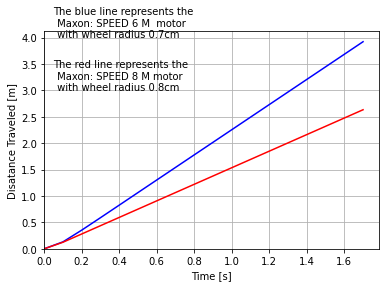

In [86]:
M6_rad = M6_d / 2
r_M6 = (M6_rad  + 4) / 1000
m_M6 = (50 + (M6_g*2) + 40) / 1000

M8_rad = M8_d / 2
r_M8 = (M8_rad  + 4) / 1000
m_M8 = (50 + (M8_g*2) + 40) / 1000

print(f"M6 wheel radius is {round(r_M6*100, 1)}cm with a mass of {m_M6}")
print(f"M8 wheel radius is {r_M8*100}cm with a mass of {m_M8}")

disp_M6 =[]
disp_M8 =[]

time = np.arange(0,1.75,0.1)

kt_M6 = M6_kt*20
rV_M6 = r_M6*M6_V

kt_M8 = M8_kt*20
rV_M8 = r_M8*M8_V

for t in time:
    k2t_M6 = (math.pow(kt_M6, 2)) * t
    k2t_M8 = (math.pow(kt_M8, 2)) * t
    
    mrR_M6 = m_M6 * r_M6 * r_M6 * M6_R
    mrR_M8 = m_M8 * r_M8 * r_M8 * M8_R
    
    expon_M6 = math.exp( -k2t_M6/ mrR_M6 )
    expon_M8 = math.exp( -k2t_M8/ mrR_M8 )

    x_t_M6 = ( rV_M6 * ( k2t_M6 + mrR_M6 * (expon_M6 - 1)))/(math.pow(kt_M6 , 3))
    x_t_M8 = ( rV_M8 * ( k2t_M8 + mrR_M8 * (expon_M8 - 1)))/(math.pow(kt_M8 , 3))
    
    disp_M6.append(x_t_M6)
    disp_M8.append(x_t_M8)


fig, ax99 = plt.subplots()
ax99.plot(time, disp_M6, '-b')
ax99.plot(time, disp_M8, '-r')
ax99.set_xlabel('Time [s]')
ax99.set_ylabel('Disatance Traveled [m]')
ax99.grid(b=None, which='both', axis='both')
ax99.text(0.05, 4, f"The blue line represents the\n {M6_name} motor \n with wheel radius {round((r_M6*100), 1)}cm")
ax99.text(0.05, 3, f"The red line represents the\n {M8_name} motor\n with wheel radius {r_M8*100}cm")
ax99.set_ylim(bottom= 0)
ax99.set_xlim(left= 0)

Lets pick the SPEED 8M motors and wheel radius of 1cm. 

Lets take a look at the Speed-Torque curve again

Angular speed for wheel radius 0.008m is 375.0rad/s
Where the low power uses an accleration of 8 m/s^2 and high power is using 13.3 m/s^2
Power low is... 2.4W and high power is 4.0W
Low torque is 6.4mNm and high torque is 10.7mNm


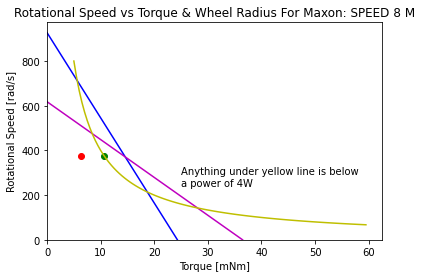

In [82]:
GEAR_RATIO1 = 4
GEAR_RATIO2 = 6

w_3ms = v_max / r_M8
no_load_w = (2*math.pi*M8_w0) / 60

P_low = m_kg * a3 * v_max
P_high = m_kg * a1 * v_max

print(f"Angular speed for wheel radius {r_M8}m is {w_3ms}rad/s")
print(f"Where the low power uses an accleration of {a3} m/s^2 and high power is using {round(a1, 1)} m/s^2")
print(f"Power low is... {round(P_low, 1)}W and high power is {P_high}W")

t_low = (P_low / w_3ms)*1000
t_high = (P_high / w_3ms)*1000

print(f"Low torque is {round(t_low, 1)}mNm and high torque is {round(t_high, 1)}mNm")


fig, ax33 = plt.subplots()
ax33.plot([0, M8_stall_t*GEAR_RATIO1*2], [no_load_w/GEAR_RATIO1, 0], '-b') #torque speed with a gear ratio
ax33.plot([0, M8_stall_t*GEAR_RATIO2*2], [no_load_w/GEAR_RATIO2, 0], '-m') #torque speed with a gear ratio
ax33.plot(t_low, w_3ms, "ro") 
ax33.plot(t_high, w_3ms, "go") 
ax33.plot(diff_torques, w_max2, '-y')
ax33.text(25, 240, f"Anything under yellow line is below \na power of {P_MAX2}W")
ax33.set_xlabel('Torque [mNm]')
ax33.set_ylabel('Rotational Speed [rad/s]')
ax33.grid(b=None, which='both', axis='both')
ax33.set_ylim(bottom= 0)
ax33.set_xlim(left= 0)

plt.title(f'Rotational Speed vs Torque & Wheel Radius For {M8_name}')
plt.grid(b=None, which='both', axis='both')
plt.show()

For a wheel radius of 0.8cm (Wheels will be 1.6cm diameter and motor is 0.8cm diameter), to achieve a linear speed of 3m/s, we need an angular velocity of 375 rad/s. Given that we will not have a constant acceleration, I chose to plot 2 potential accelerations, just for visualization sake. The red dot represents an acceleration of 8 m/s^2 while the green dot represents an acceleration of 13 m/s^2. Using a simple power calculation, I found the torques necessary to achieve these accelerations and plotted them (as the red and green dots). This proves that for gear ratios between 4 and 6, we will be able to reach 3m/s given a non constant torque. 

Where the low power uses an accleration of 8 m/s^2 and high power is using 13.3 m/s^2
Power low is... 2.4W and high power is 4.0W
Low torque is 5.6mNm and high torque is 9.3mNm


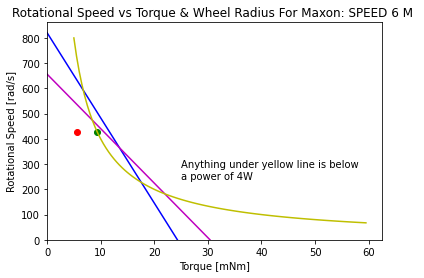

In [83]:
GEAR_RATIO1 = 8
GEAR_RATIO2 = 10

w_3ms = v_max / r_M6
no_load_w = (2*math.pi*M6_w0) / 60

P_low = m_kg * a3 * v_max
P_high = m_kg * a1 * v_max

print(f"Where the low power uses an accleration of {a3} m/s^2 and high power is using {round(a1, 1)} m/s^2")
print(f"Power low is... {round(P_low, 1)}W and high power is {P_high}W")

t_low = (P_low / w_3ms)*1000
t_high = (P_high / w_3ms)*1000

print(f"Low torque is {round(t_low, 1)}mNm and high torque is {round(t_high, 1)}mNm")


fig, ax33 = plt.subplots()
ax33.plot([0, M6_stall_t*GEAR_RATIO1*2], [no_load_w/GEAR_RATIO1, 0], '-b') #torque speed with a gear ratio
ax33.plot([0, M6_stall_t*GEAR_RATIO2*2], [no_load_w/GEAR_RATIO2, 0], '-m') #torque speed with a gear ratio
ax33.plot(t_low, w_3ms, "ro") 
ax33.plot(t_high, w_3ms, "go") 
ax33.set_xlabel('Torque [mNm]')
ax33.plot(diff_torques, w_max2, '-y')
ax33.text(25, 240, f"Anything under yellow line is below \na power of {P_MAX2}W")
ax33.set_ylabel('Rotational Speed [rad/s]')
ax33.grid(b=None, which='both', axis='both')
ax33.set_ylim(bottom= 0)
ax33.set_xlim(left= 0)

plt.title(f'Rotational Speed vs Torque & Wheel Radius For {M6_name}')
plt.grid(b=None, which='both', axis='both')
plt.show()